In [1]:
import pandas as pd
import numpy as np
import glob
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import datetime
import heapq as heap
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score
pd.options.display.max_columns = 1200
pd.options.display.max_rows = 1200

Instructions for updating:
non-resource variables are not supported in the long term


# Data Processing

In [5]:
# Read in all of our Autoperf monthly datasets and combine into one dataset
apdf1 = pd.concat(
    [pd.read_csv(filename, header=0, low_memory=False) for filename in glob.glob("../data/ap-all/autoperf-2018-?.csv")], 
    axis=0, 
    ignore_index=True
)
apdf2 = pd.concat(
    [pd.read_csv(filename, header=0, low_memory=False) for filename in glob.glob("../data/ap-all/autoperf-2018-??.csv")], 
    axis=0, 
    ignore_index=True
)
apdf = pd.concat([apdf1, apdf2], axis=0, ignore_index=True)

In [6]:
len(apdf.zero_csJobId.unique())

281895

In [7]:
# Full dataset contains jobs from Cetus and Mira: this cell filters out Cetus
miraids = pd.read_csv('../data/autoperf_complete/mira_joblist.csv', header=None)[0].values.tolist()
miradf = apdf[apdf.zero_batchJobId.isin(miraids)]
# miradf = apdf.copy()

In [8]:
len(miradf.zero_csJobId.unique())

127585

In [9]:
# Filter and randomize data for training later on
n = 20

## Filter by top n core hour consumers
# df_filtered = pd.DataFrame()
# if n > 0:
#     names = miradf.zero_execName.unique()
#     core_hours_dict = {}
#     for name in names:
#         core_hours_dict.update({name : (miradf.av_elapsedTime * miradf.av_numRanks).sum()})
#     top_names = heap.nlargest(n, core_hours_dict, key=core_hours_dict.get)
#     for name in top_names:
#         df_filtered = df_filtered.append(miradf[miradf['zero_execName'] == name])
# else:
#     df_filtered = miradf.copy()

# Filter by most frequent
# df_values = miradf.zero_execName.value_counts().head(n)
# df_filtered = miradf[miradf["zero_execName"] in df_values]

n_top_execs = miradf.zero_execName.value_counts().head(n)
not_n_top_execs = [executable for executable in miradf.zero_execName.unique() if executable not in n_top_execs]
# df_filtered = miradf[miradf.zero_execName.isin(n_top_execs.keys())]
df_filtered = miradf.copy()
df_filtered.loc[df_filtered.zero_execName.isin(not_n_top_execs), 'zero_execName'] = 'other'

df_filtered = df_filtered.sample(frac=1)

In [10]:
len(df_filtered.zero_execName.unique())

21

In [11]:
# Select features and targets for ML models

features = df_filtered.drop(['zero_execName', 'run_date', 'zero_userName', 
                             'zero_threadMode', 'min_userName', 'min_execName', 'min_threadMode', 
                             'max_execName', 'max_userName', 'max_threadMode', 'av_execName', 'av_userName', 'av_threadMode',
                             'zero_csJobId', 'zero_batchJobId', 'output_local',
                             'output_sys'
                            ], 
    axis=1).select_dtypes(include=[np.number]).copy()

features = features.drop([column for column in features.columns if 'mpi' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'torus' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'version' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'env' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'debug' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'disable' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'cycle' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'rank' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'jobid' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'batchid' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'rank' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'username' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'execname' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'time' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'numprocesses' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'threads' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'heapmaxused' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'zero_' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'min_' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if 'max_' in column.lower()], axis=1)
features = features.drop([column for column in features.columns if features[column].max() == features[column].min()], axis=1)

# Factorize the targets for softmax classification (trying to predict executable name)
targets = pd.DataFrame()
targets['number'] = pd.factorize(df_filtered['zero_execName'])[0]

In [12]:
features.columns

Index(['av_PEVT_LSU_COMMIT_LD_MISSES', 'av_PEVT_LSU_COMMIT_CACHEABLE_LDS',
       'av_PEVT_L1P_BAS_MISS', 'av_PEVT_INST_XU_ALL', 'av_PEVT_INST_QFPU_ALL',
       'av_PEVT_INST_QFPU_FPGRP1', 'av_PEVT_L2_HITS', 'av_PEVT_L2_MISSES',
       'av_PEVT_L2_FETCH_LINE', 'av_PEVT_L2_STORE_LINE',
       'av_PEVT_NW_USER_PP_SENT', 'av_PEVT_NW_USER_PP_RECV'],
      dtype='object')

In [15]:
# Normalize to +/-1
# features = ((features - features.mean()) / (features.max() - features.min())).fillna(value = 0, axis=0, )#.dropna(axis=0, how='any')

### OR ###

# Normalize by elapsed time
def elapsedTimeNormalization(column):
    return column / df_filtered.av_elapsedTime
features = features.apply(elapsedTimeNormalization).fillna(value = 0, axis=0)

### OR ###

# Just remove nans
# features = features.fillna(value = 0, axis=0)

In [17]:
# Check how many feature columns we have
print(len(features.columns))
# features.columns

12


In [18]:
# Separate our data into training and test sets
train_size = .7

train_examples = features.head(int(len(df_filtered.index) * train_size))
train_targets = targets.head(int(len(df_filtered.index) * train_size))
test_examples = features.tail(int(len(df_filtered.index) * (1-train_size)))
test_targets = targets.tail(int(len(df_filtered.index) * (1-train_size)))

In [19]:
# How many unique executables do we have?
targets.number.unique().size

21

# Tensorflow Model Training

In [149]:
# Define our TensorFlow model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, activation='relu', input_shape=(len(features.columns.values),)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
  tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
  tf.keras.layers.Dense(targets.number.unique().size, activation='softmax')
])

In [150]:
# Compile our model
model.compile(optimizer=tf.train.AdagradOptimizer(0.005),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'],
            )

In [151]:
# Train model
model.fit(train_examples, 
          train_targets, 
          epochs=10,
         )

Train on 18139 samples
Epoch 1/10
18139/18139 [==============================] - 1s 55us/sample - loss: 9409930.5302 - sparse_categorical_accuracy: 0.6392
Epoch 2/10
18139/18139 [==============================] - 1s 49us/sample - loss: 571233.4883 - sparse_categorical_accuracy: 0.7728
Epoch 3/10
18139/18139 [==============================] - 1s 49us/sample - loss: 252817.9341 - sparse_categorical_accuracy: 0.8214
Epoch 4/10
18139/18139 [==============================] - 1s 49us/sample - loss: 306159.2402 - sparse_categorical_accuracy: 0.8369
Epoch 5/10
18139/18139 [==============================] - 1s 50us/sample - loss: 151689.2910 - sparse_categorical_accuracy: 0.8498
Epoch 6/10
18139/18139 [==============================] - 1s 50us/sample - loss: 94350.6889 - sparse_categorical_accuracy: 0.8637
Epoch 7/10
18139/18139 [==============================] - 1s 57us/sample - loss: 75179.4050 - sparse_categorical_accuracy: 0.8706
Epoch 8/10
18139/18139 [==============================] - 1s 

In [152]:
test_acc = model.evaluate(test_examples, test_targets)
print('Test accuracy:', test_acc)

4534/4534 [==============================] - 0s 54us/sample - loss: 88496.6230 - sparse_categorical_accuracy: 0.8880
Test accuracy: [88496.62298053595, 0.88795763]


# T-SNE Graphing

In [27]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [28]:
# Train T-SNE
X_embedded = TSNE().fit_transform(features)
X_embedded.shape

(127585, 2)

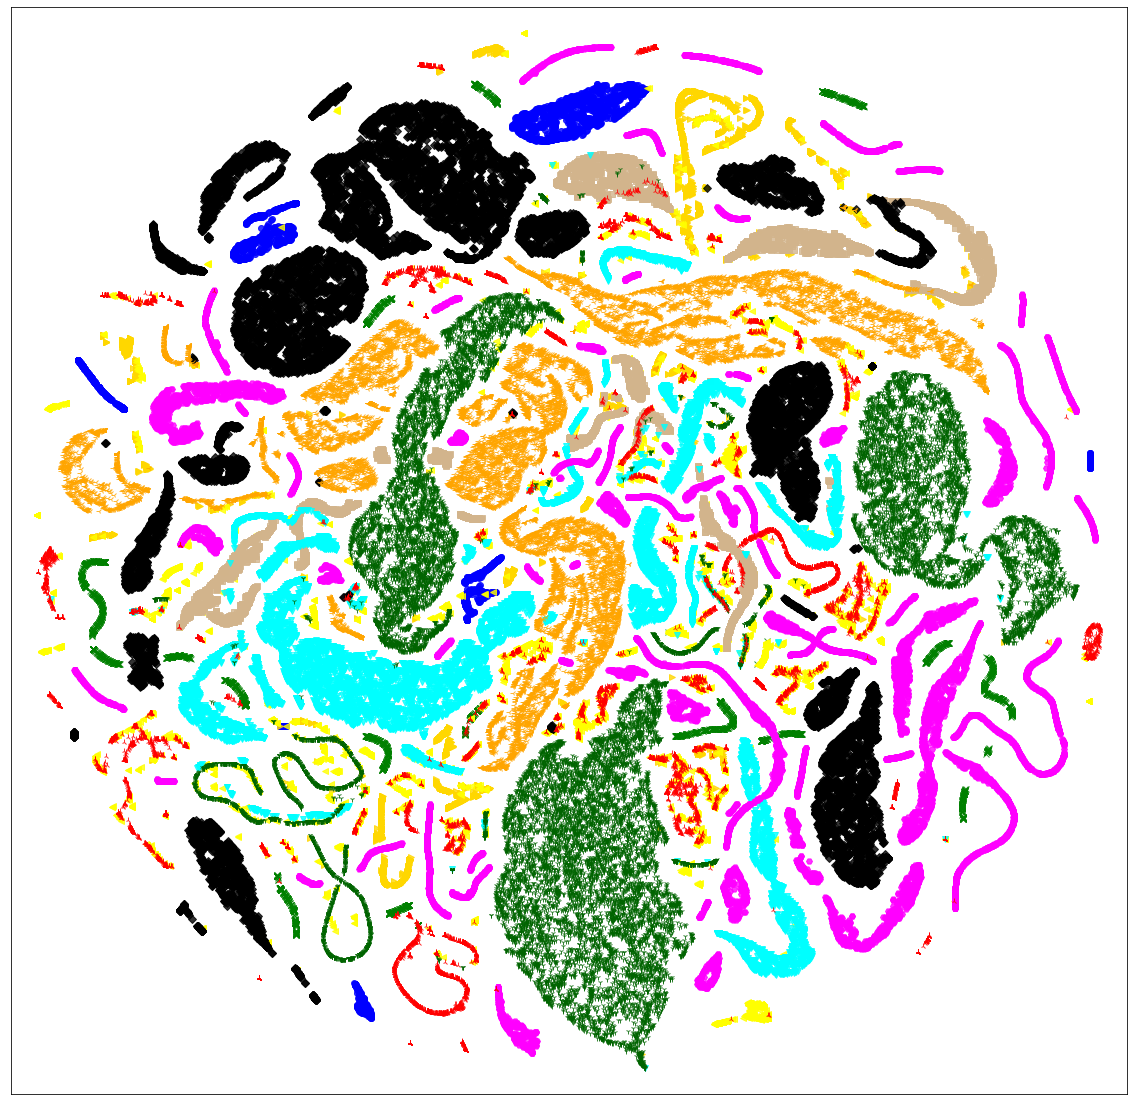

In [36]:
def t_sne_vis_by_group(x_emb, exe_idn, topn=10):
    idn_unique, idn_count = np.unique(exe_idn, return_counts=True)
    top_idn = idn_unique[np.argsort(idn_count)[-topn:]]
    plt.figure(figsize=(20, 20))
    colors = ('g', 'b', 'gold', 'yellow', 'tan', 'cyan', 'magenta', 'black', 'orange', 'darkgreen')
    markers= ('x', 'o', '>', '<', 's', 'v', 'H', 'D', '3', '1', '2')
    _other_grp = np.zeros(exe_idn.shape[0], dtype=np.bool)
    for _idx, _idn in enumerate(top_idn):
        _emb_grp = x_emb[exe_idn == _idn]
        plt.plot(_emb_grp[:, 0], _emb_grp[:, 1], markers[_idx], alpha=.8, color=colors[_idx], markersize=6, label = _idn)
        _other_grp |= (exe_idn == _idn)
#         print("%s is marked by %s and %s" % (_idn, colors[_idx], markers[_idx]))
    _uncat = x_emb[~_other_grp]
    plt.plot(_uncat[:, 0], _uncat[:, 1], markers[-1], alpha=.8, color='r', markersize=6, label = 'Others')
    
    plt.xlim(left=X_embedded[:, 0].min()*1.05, right=X_embedded[:, 0].max()*1.05)
    plt.ylim(bottom=X_embedded[:, 1].min()*1.05, top=X_embedded[:, 1].max()*1.05)
    plt.xticks([])
    plt.yticks([])
#     plt.legend(bbox_to_anchor=(0., 1.0, 1., .102), ncol=4, loc=3, fancybox=True, framealpha=0.5, fontsize=14)
    plt.savefig('../figure/tsne-counters-only.pdf')
    plt.show()
    plt.close()
t_sne_vis_by_group(X_embedded, df_filtered['zero_execName'].values)

# XGBoost Model

In [20]:
train_examples = features.head(int(len(df_filtered.index) * train_size))
train_targets = targets.head(int(len(df_filtered.index) * train_size))
test_examples = features.tail(int(len(df_filtered.index) * (1-train_size)))
test_targets = targets.tail(int(len(df_filtered.index) * (1-train_size)))

In [21]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", max_depth=10)
xgb_model.fit(train_examples, train_targets.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
accuracy_score(test_targets, xgb_model.predict(test_examples))

0.9912998040496408

In [23]:
recall_score(test_targets, xgb_model.predict(test_examples), average='macro')

0.9629223244707413

In [24]:
precision_score(test_targets, xgb_model.predict(test_examples), average='macro')

0.9679272239901409

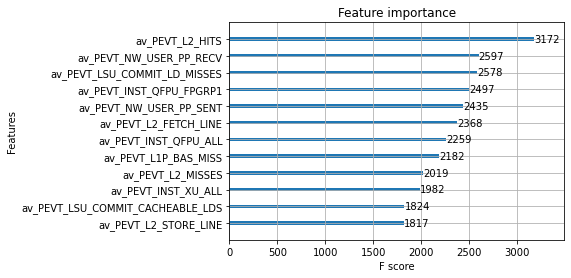

In [25]:
xgb.plot_importance(xgb_model, importance_type='weight')

In [26]:
df_filtered.zero_execName.value_counts() / len(df_filtered)

aims.160328_3.scalapack.mpi.x     0.211577
ks_spectrum_hisq                  0.149775
qlua                              0.146687
mcfm_omp                          0.140275
converge                          0.106517
distress                          0.046471
other                             0.045366
nek5000                           0.032324
dns                               0.022902
qlua-bkend                        0.021492
project_dyn                       0.020096
xmfdn-menj_BGQ-lan                0.010714
rwalk                             0.008810
aims.071914_7.scalapack.mpi.x     0.007595
wrf.exe                           0.005902
cpmd_3.17.1.dat                   0.004554
nwchem-6.6-dft-hf-mp2-only.off    0.004389
vof.exe                           0.004240
cesm.exe                          0.004044
rwalk-xpoff                       0.003135
miniFE.V1R2M4-xl.x                0.003135
Name: zero_execName, dtype: float64